# Reproduce the pancreatic endocrinogenesis case study of DeepVelo

In this notebook, we follow the instructions of DeepVelo and are able to reproduce the case study of pancreatic endocrinogenesis by [Cui et al.](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2.full) in bioRxiv (doi: https://doi.org/10.1101/2022.04.03.486877; version 2).

## Build environment and install dependencies

We create the environment of DeepVelo by running the commands below in an anaconda environment. We download and install DeepVelo from https://github.com/bowang-lab/DeepVelo on the main thread on 08/03/2022 (version: 0.2.5rc1). The code could also be downloaded [here](https://github.com/bowang-lab/DeepVelo).

`conda create -n deepvelo python=3.7.6`

`conda activate deepvelo`

`pip install 'your_path/DeepVelo'`

# Import packages

In [1]:
import numpy as np
import scvelo as scv
import torch
from scipy.stats import mannwhitneyu
import anndata as ann

from deepvelo.utils import velocity, velocity_confidence, latent_time, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

# set seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params("scvelo", transparent=False)  # for beautified visualization

%load_ext autoreload
%autoreload 2

# Load pancreatic endocrinogenesis data

We demonstrate the full training pipeline using an example of the pancreatic endocrinogenesis data from scVelo.

In [2]:
adata = scv.datasets.pancreas()

# Preprocessing

We apply exactly the same preprocessing steps as DeepVelo.

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

adata

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

# Run DeepVelo

We run DeepVelo with the same configurations in the instruction. We set n_gpu to 0 to run DeepVelo in CPU. 

In [4]:
# specific configs to overide the default configs
configs = {"name": "DeepVelo_reproducing", # name of the experiment
           "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}}, # The ratio of spliced reads is 83.2% (between 70% and 85%). Suggest using coeff_s 0.75.
           "trainer": {"verbosity": 0}, # increase verbosity to show training progress
           "n_gpu":0, # enable to use CPU
          }
           
configs = update_dict(Constants.default_configs, configs)

The ratio of spliced reads is 83.2% (between 70% and 85%). Suggest using coeff_s 0.75.


In [5]:
# initial velocity
velocity(adata, mask_zero=False)

trainer = train(adata, configs)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo_reproducing ...


velo data shape: torch.Size([3696, 2000])
velo_mat shape: (3696, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


# Plot velocity in embedding space (Fig. 4b in [Cui et al.](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2.full))

We follow the instructions of DeepVelo to plot the RNA velocity in embedding space.

computing velocity graph (using 8/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


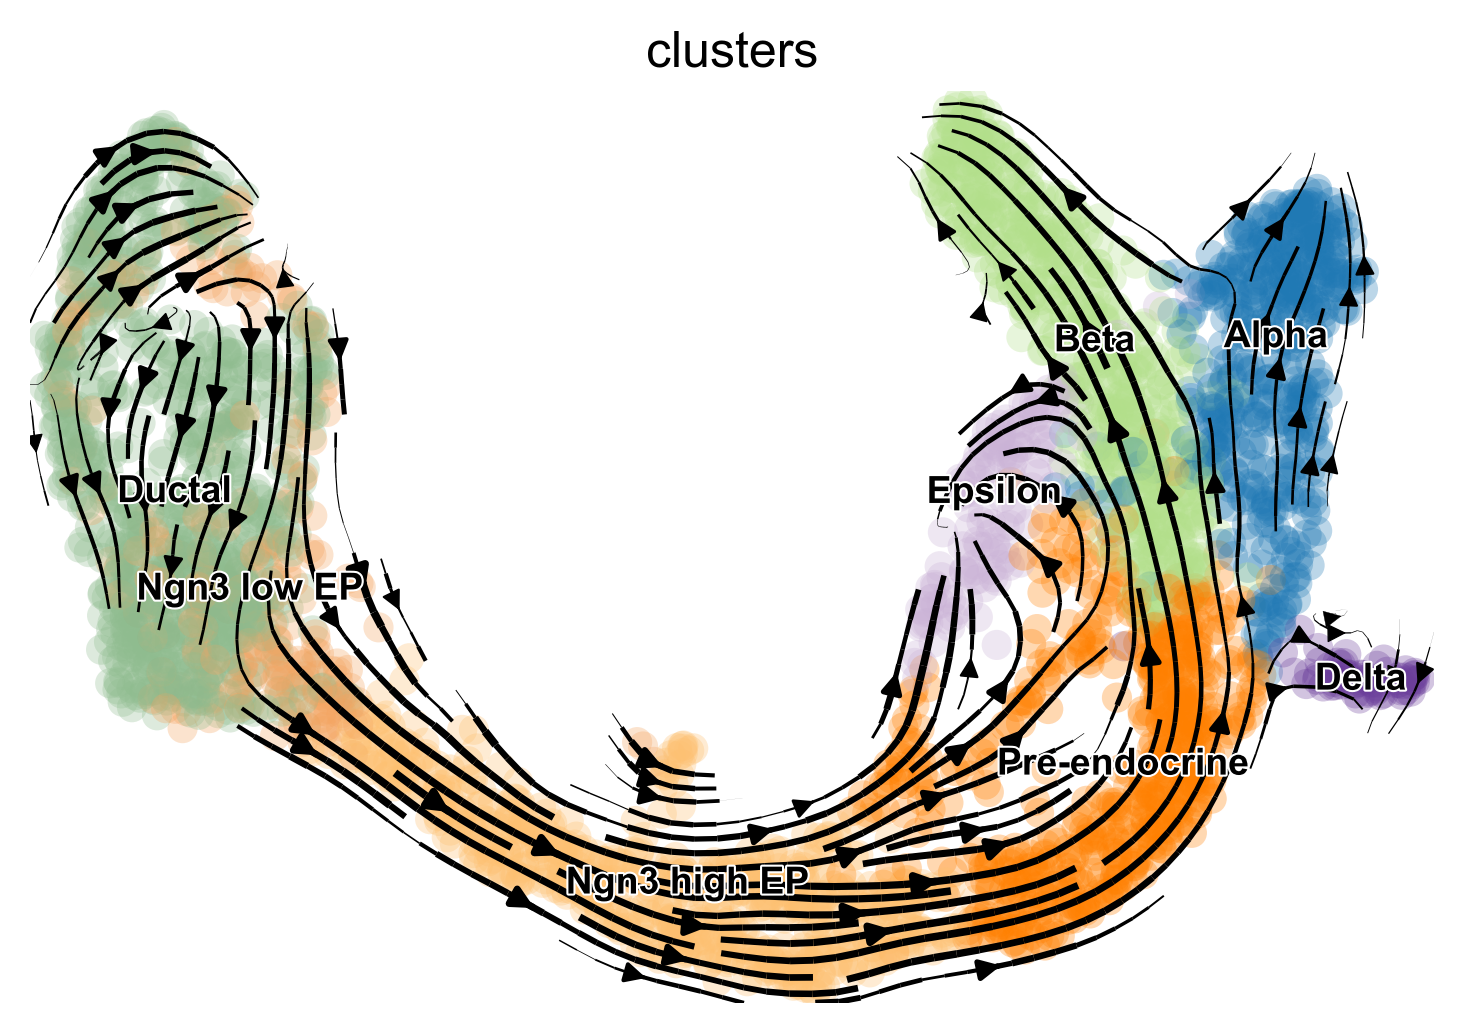

In [6]:
scv.tl.velocity_graph(adata, n_jobs=8)

# velocity plot
scv.pl.velocity_embedding_stream(adata,basis="umap", color="clusters", legend_fontsize=9, dpi=150)

# Plot pseudotime in embedding space (Fig. 4a in [Cui et al.](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2.full))

We follow the instructions of DeepVelo to calculate and display the pseudotime.

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


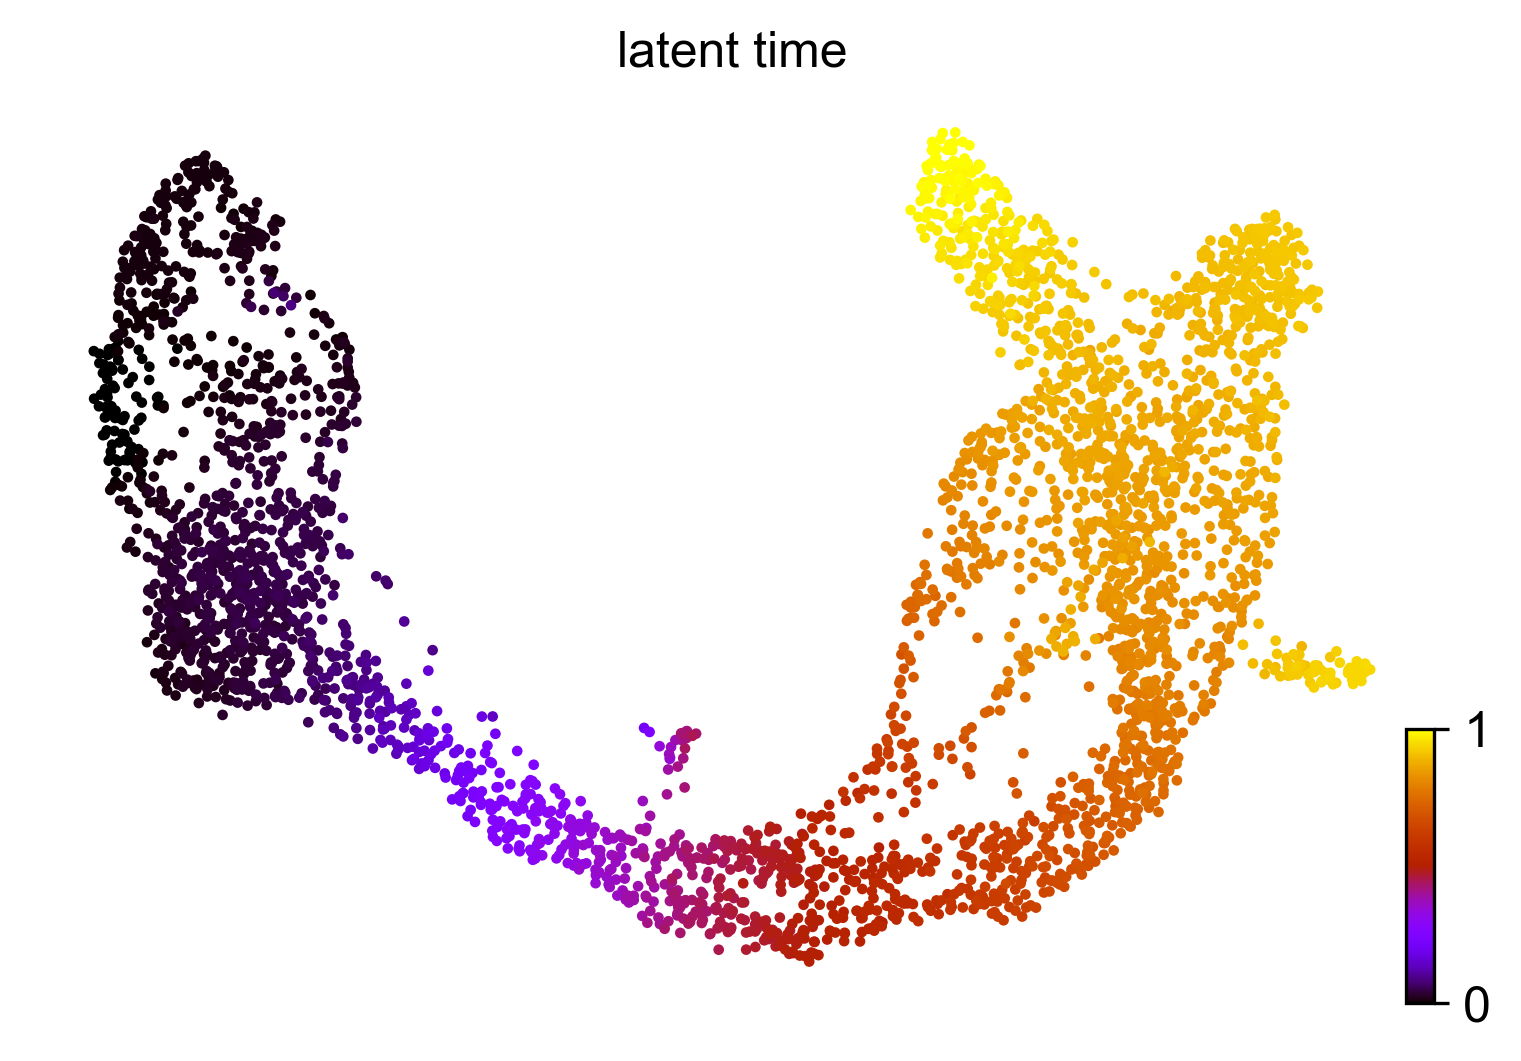

In [7]:
latent_time(adata)
scv.pl.scatter(adata, color="latent_time", color_map="gnuplot", dpi=150)